# Causal discovery with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results.
This tutorial explains the available conditional independence tests for different types of variables.

This table gives an overview of tests and their associated assumptions.

| Conditional independence test | Assumptions                                  |
|--------|---------------------------------------------------------------------------|
| ParCorr  | univariate, continuous variables with linear dependencies and Gaussian noise |
| RobustParCorr  | univariate, continuous variables with linear dependencies, robust for different marginal distributions |
| ParCorrWLS  | univariate, continuous variables with linear dependencies, can account for heteroskedastic data |
| GPDC / GPDCtorch | univariate, continuous variables with additive dependencies        |
| CMIknn | multivariate, continuous variables with more general dependencies (permutation-based test)          |
| Gsquared | univariate discrete/categorical variables           |
| CMIsymb | multivariate discrete/categorical variables (permutation-based test)           |
| RegressionCI | mixed datasets with univariate discrete/categorical and (linear) continuous variables 

The density plots discussed in the overview tutorial can help choose which test to use.

It is important to note that the tests that make less strong assumptions, will have much lower detection power than tests with stronger assumptions. For example, ParCorr will work much better than CMIknn for dependencies that are actually linear. Furthermore, non-parametric tests are much more computationally expensive.


In [24]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI

from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.parcorr_wls import ParCorrWLS
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.regressionCI import RegressionCI

## 1. Continuously-valued variables

### 1.1 ParCorr

Partial correlation (``ParCorr`` class) is explained in the overview tutorial.

### 1.2 RobustParCorr

If there are still linear dependencies, but non-gaussian distributions, it is advisable to use the ``RobustParCorr`` test which transforms the data to a normal distribution prior to the partial correlation test. 

Here we also showcase the new function ``toys.generate_structural_causal_process`` which allows to randomly create structural causal process models with a number of parameters (see docstring). In the following the noise terms are from an extremal Weibull and uniform distribution. Further, we apply some polynomial transformations that make the data even more extreme.

0 [((0, -1), 0.5, 'linear'), ((2, -1), -0.5, 'linear'), ((1, -2), 0.5, 'linear')]
weibull
1 [((1, -1), 0.3, 'linear'), ((0, -2), -0.5, 'linear')]
weibull
2 [((2, -1), 0.3, 'linear'), ((0, -2), 0.5, 'linear')]
uniform


(<Figure size 640x480 with 3 Axes>,
 array([<AxesSubplot:ylabel='$X^0$'>, <AxesSubplot:ylabel='$X^1$'>,
        <AxesSubplot:ylabel='$X^2$'>], dtype=object))

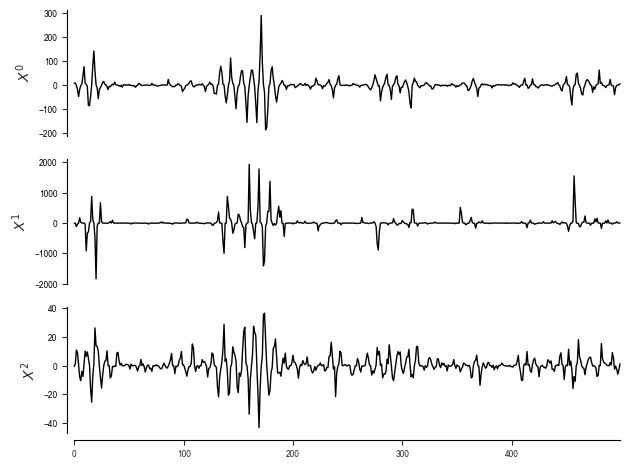

In [25]:
# np.random.seed(1)
T = 500
links, noises = toys.generate_structural_causal_process(
                N=3, 
                L=4, 
                dependency_funcs=['linear'], 
                dependency_coeffs=[-0.5, 0.5], 
                auto_coeffs=[0.3, 0.5], 
                contemp_fraction=0.,
                max_lag=2, 
                noise_dists=['weibull', 'uniform'],
                noise_means=[0.],
                noise_sigmas=[1., 1.5],
                noise_seed=5,
                seed=9)
for j in links:
    print(j, [(link[0], link[1], link[2].__name__) for link in links[j]])
    print(noises[j].__name__)
data, nonstat = toys.structural_causal_process(links,
             T=T, noises=noises)
data[:,0] = data[:,0] + 0.3*data[:,0]**3
data[:,1] = data[:,1] + 0.3*data[:,1]**5
data[:,2] = np.sign(data[:,2])*data[:,2]**2
var_names = [r'$X^0$', r'$X^1$', r'$X^2$']

dataframe = pp.DataFrame(data, var_names=var_names)
tp.plot_timeseries(dataframe)

In [26]:
# Init
pcmci_robust_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=RobustParCorr())

We can illustrate the skewed marginal and joint densities with the density plot feature. Here we standardize the skewed data to show that it is strongly non-gaussian

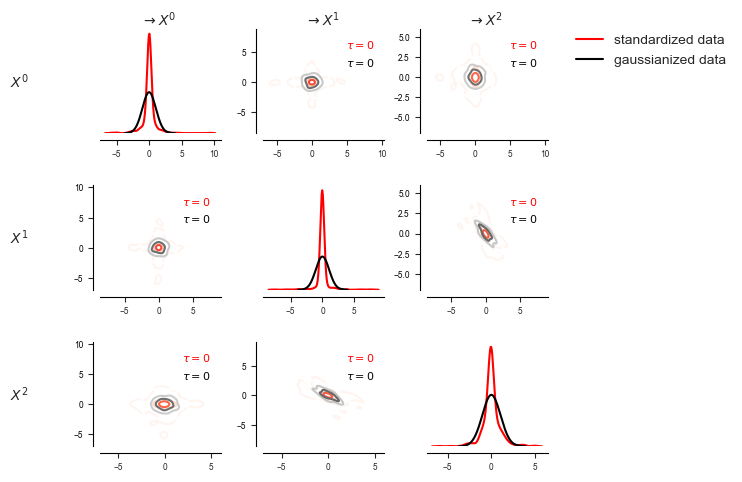

In [27]:
# tp.plot_densityplots(dataframe=dataframe, add_densityplot_args={'matrix_lags':matrix_lags}); plt.show()
# correlations = pcmci_robust_parcorr.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
# matrix_lags = np.argmax(np.abs(correlations), axis=2)
matrix_lags = None

matrix = tp.setup_density_matrix(N=dataframe.N, 
        var_names=dataframe.var_names)

# Standardize to better compare skewness with gaussianized data
dataframe.values[0] -= dataframe.values[0].mean(axis=0)
dataframe.values[0] /= dataframe.values[0].std(axis=0)

matrix.add_densityplot(dataframe=dataframe, 
    matrix_lags=matrix_lags, label_color='red', label="standardized data",
    snskdeplot_args = {'cmap':'Reds', 'alpha':1., 'levels':4})

# Transform data to normal marginals
data_normal = pp.trafo2normal(data)
dataframe_normal = pp.DataFrame(data_normal, var_names=var_names)

matrix.add_densityplot(dataframe=dataframe_normal, 
    matrix_lags=matrix_lags, label_color='black', label="gaussianized data",
    snskdeplot_args = {'cmap':'Greys', 'alpha':1., 'levels':4})
matrix.adjustfig()
# plt.show()


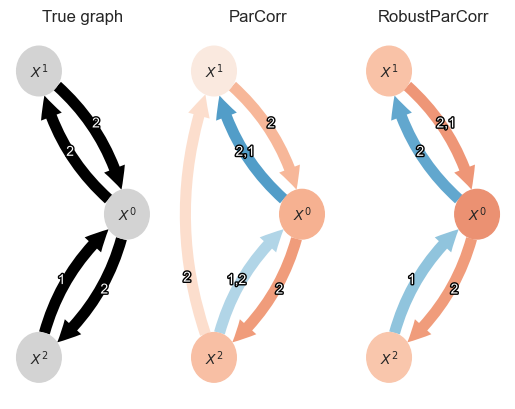

In [29]:
pcmci_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=ParCorr())
results = pcmci_parcorr.run_pcmci(tau_max=2)

pcmci_robust_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=RobustParCorr())
results_robust = pcmci_robust_parcorr.run_pcmci(tau_max=2)

fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].set_title("True graph")
tp.plot_graph(
    graph=pcmci_robust_parcorr.get_graph_from_dict(links, tau_max=None),
    var_names=var_names,
    fig_ax=(fig, axes[0]),
    show_colorbar=False,
    )


axes[1].set_title("ParCorr")
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    fig_ax=(fig, axes[1]),
    show_colorbar=False,
    )

axes[2].set_title("RobustParCorr")
tp.plot_graph(
    val_matrix=results_robust['val_matrix'],
    graph=results_robust['graph'],
    var_names=var_names,
    fig_ax=(fig, axes[2]),
    show_colorbar=False,
    )
plt.show()

``RobustParCorr`` (right) here yields more reliable results than standard ``ParCorr`` (left) since the marginal distributions are transformed to normal beforehand.

In the tutorial ``tigramite_tutorial_heteroskedastic_ParCorrWLS`` we cover another version of partial correlation that is applicable to heteroskedastic data, called ``ParCorrWLS``.

### Nonlinear tests

If nonlinear dependencies are present, it is advisable to use a nonparametric test. Consider the following model:

\begin{align*}
    X^0_t &= 0.4 (X^1_{t-1})^2 + \eta^0_t\\
    X^1_t &= \eta^1_t \\
    X^2_t &= 0.3 (X^1_{t-2})^2 + \eta^2_t
\end{align*}

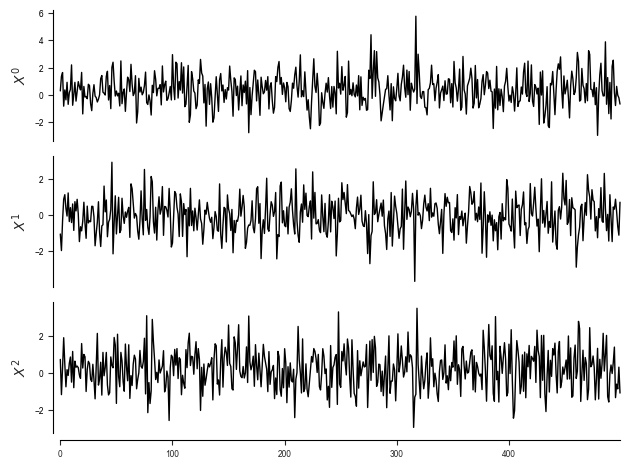

In [6]:
random_state = np.random.default_rng(seed=42)
data = random_state.standard_normal((500, 3))
for t in range(1, 500):
    data[t, 0] += 0.4*data[t-1, 1]**2
    data[t, 2] += 0.3*data[t-2, 1]**2
var_names = [r'$X^0$', r'$X^1$', r'$X^2$']

dataframe = pp.DataFrame(data, var_names=var_names)
tp.plot_timeseries(dataframe); plt.show()

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

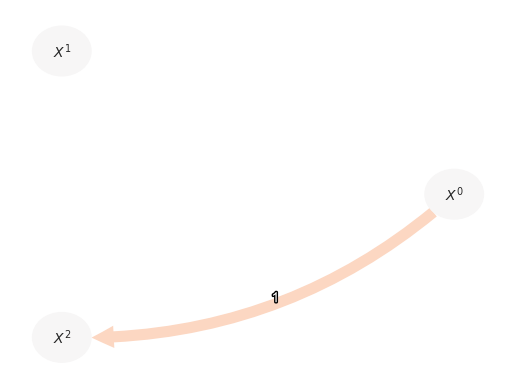

In [7]:
pcmci_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=ParCorr(),
    verbosity=0)
results = pcmci_parcorr.run_pcmci(tau_max=2, pc_alpha=0.2, alpha_level = 0.01)
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    show_colorbar=False,
    )

``ParCorr`` here fails in two ways: (1) It cannot detect the two nonlinear links, (2) it wrongly detects a link $X^0_{t-1} \to X^2_t$ because it also cannot *condition out* a nonlinear dependency.

### 1.3 GPDC

Tigramite covers nonlinear additive dependencies with a test based on *Gaussian process* regression and a *distance correlation* (``GPDC``) on the residuals. For GPDC no analytical null distribution of the distance correlation (DC) is available. For significance testing, Tigramite with the parameter ``significance = 'analytic'`` pre-computes the distribution for each sample size (stored in memory), thereby avoiding computationally expensive permutation tests for each conditional independence test (``significance = 'shuffle_test'``). GP regression is performed with ``sklearn`` default parameters, except for the *kernel* which here defaults to the radial basis function + a white kernel (both hyperparameters are internally optimized) and the assumed noise level ``alpha`` which is set to zero since we added a white kernel. These and other parameters can be set via the ``gp_params`` dictionary. See the documentation in ``sklearn`` for further discussion. There also exists a module (``gpdc_torch.py``) which exploits ``gpytorch`` for faster computations on GPUs.

In [8]:
gpdc = GPDC(significance='analytic', gp_params=None)
pcmci_gpdc = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=gpdc,
    verbosity=0)

In contrast to ParCorr, the nonlinear links are correctly detected with GPDC:

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

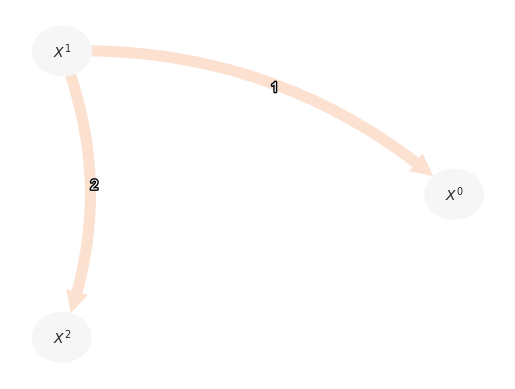

In [9]:
results = pcmci_gpdc.run_pcmci(tau_max=2, pc_alpha=0.1, alpha_level = 0.01)
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    show_colorbar=False,
    )

As a short excursion, we can see how GPDC works by looking at the scatter plots:

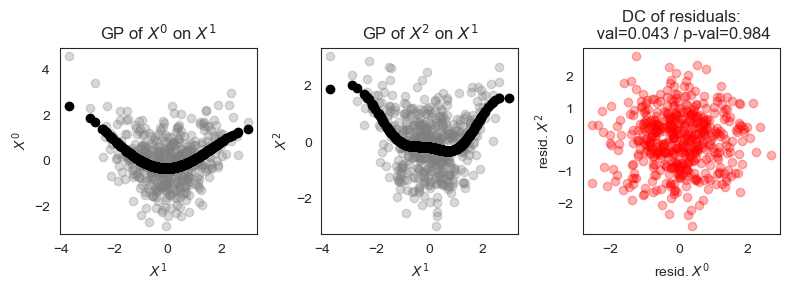

In [10]:
array, dymmy, dummy, dummy = gpdc._get_array(X=[(0, -1)], Y=[(2, 0)], Z=[(1, -2)], tau_max=2)
x, meanx = gpdc._get_single_residuals(array, target_var=0, return_means=True)
y, meany = gpdc._get_single_residuals(array, target_var=1, return_means=True)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,3))
axes[0].scatter(array[2], array[0], color='grey', alpha=0.3)
axes[0].scatter(array[2], meanx, color='black')
axes[0].set_title("GP of %s on %s" % (var_names[0], var_names[1]) )
axes[0].set_xlabel(var_names[1]); axes[0].set_ylabel(var_names[0])
axes[1].scatter(array[2], array[1], color='grey', alpha=0.3)
axes[1].scatter(array[2], meany, color='black')
axes[1].set_title("GP of %s on %s" % (var_names[2], var_names[1]) )
axes[1].set_xlabel(var_names[1]); axes[1].set_ylabel(var_names[2])
axes[2].scatter(x, y, color='red', alpha=0.3)
axes[2].set_title("DC of residuals:" "\n val=%.3f / p-val=%.3f" % (gpdc.run_test(
            X=[(0, -1)], Y=[(2, 0)], Z=[(1, -2)], tau_max=2)) )
axes[2].set_xlabel("resid. "+var_names[0]); axes[2].set_ylabel("resid. "+var_names[2])
plt.tight_layout()

Let's look at some even more nonlinear dependencies in a model with multiplicative noise:

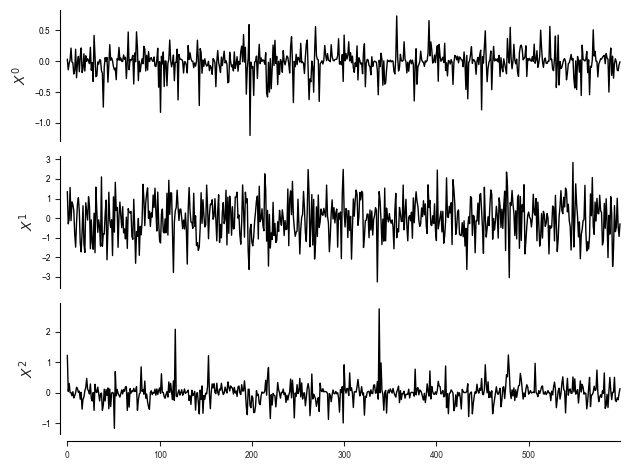

In [11]:
random_state = np.random.default_rng(seed=11)
data = random_state.standard_normal((600, 3))
for t in range(1, 600):
    data[t, 0] *= 0.2*data[t-1, 1]
    data[t, 2] *= 0.3*data[t-2, 1]
dataframe = pp.DataFrame(data, var_names=var_names)
tp.plot_timeseries(dataframe); plt.show()

Since multiplicative noise violates the assumption of additive dependencies underlying GPDC, the spurious link  $X^0_{t-1} \to X^2_t$ is wrongly detected because it cannot be *conditioned out*. In contrast to ParCorr, however, the two true links *are* detected because DC detects any kind of dependency (There might be warnings from the underlying sklearn gaussian process function):

/home/jakobrunge/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/jakobrunge/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

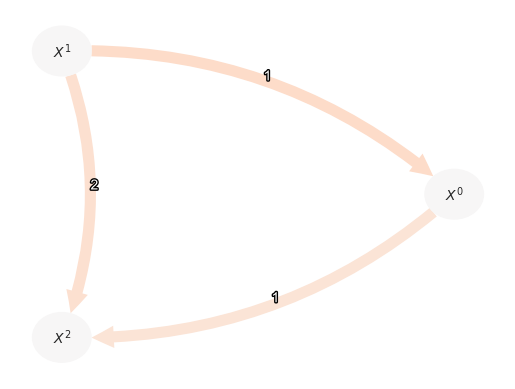

In [12]:
pcmci_gpdc = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=gpdc)
results = pcmci_gpdc.run_pcmci(tau_max=2, pc_alpha=0.1, alpha_level = 0.01)
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    show_colorbar=False,
    )

Here we can see in the scatter plot, that the Gaussian Process cannot fit the dependencies and the residuals are, thus, not independent.

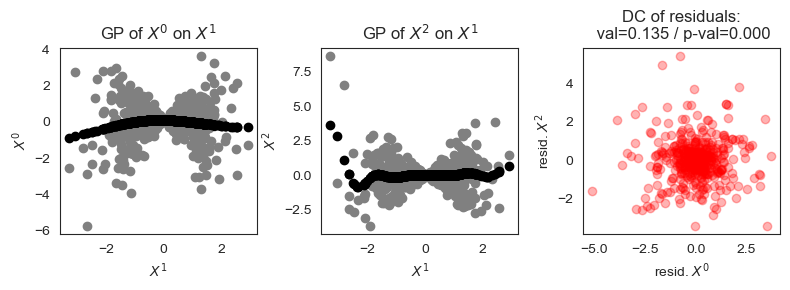

In [13]:
array, dymmy, dummy, dummy = gpdc._get_array(X=[(0, -1)], Y=[(2, 0)], Z=[(1, -2)], tau_max=2)
x, meanx = gpdc._get_single_residuals(array, target_var=0, return_means=True)
y, meany = gpdc._get_single_residuals(array, target_var=1, return_means=True)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,3))
axes[0].scatter(array[2], array[0], color='grey')
axes[0].scatter(array[2], meanx, color='black')
axes[0].set_title("GP of %s on %s" % (var_names[0], var_names[1]) )
axes[0].set_xlabel(var_names[1]); axes[0].set_ylabel(var_names[0])
axes[1].scatter(array[2], array[1], color='grey')
axes[1].scatter(array[2], meany, color='black')
axes[1].set_title("GP of %s on %s" % (var_names[2], var_names[1]) )
axes[1].set_xlabel(var_names[1]); axes[1].set_ylabel(var_names[2])
axes[2].scatter(x, y, color='red', alpha=0.3)
axes[2].set_title("DC of residuals:" "\n val=%.3f / p-val=%.3f" % (gpdc.run_test(
            X=[(0, -1)], Y=[(2, 0)], Z=[(1, -2)], tau_max=2)) )
axes[2].set_xlabel("resid. "+var_names[0]); axes[2].set_ylabel("resid. "+var_names[2])
plt.tight_layout()

### 1.4 CMIknn

The most general conditional independence test implemented in Tigramite is CMIknn based on conditional mutual information estimated with a k-nearest neighbor estimator. This test is described in the paper 

Runge, Jakob. 2018. “Conditional Independence Testing Based on a Nearest-Neighbor Estimator of Conditional Mutual Information.” In Proceedings of the 21st International Conference on Artificial Intelligence and Statistics. 

CMIknn involves no assumptions about the dependencies. The parameter ``knn`` determines the size of hypercubes, ie., the (data-adaptive) local length-scale. Now we cannot even pre-compute the null distribution because CMIknn is not residual-based like GPDC and the null distribution depends on many more factors. We, therefore, use ``significance='shuffle_test'`` to generate it in each individual test. The shuffle test for testing $I(X;Y|Z)=0$ shuffles $X$ values *locally*: Each sample point $i$’s $x$-value is mapped randomly
to one of its nearest neigbors (``shuffle_neighbors`` parameter) in subspace $Z$. Another free parameter is ``transform`` which specifies whether data is transformed before CMI estimation. The new default is ``transform=ranks`` which works better than the old ``transform=standardize``.
The following cell may take some minutes.

In [14]:
cmi_knn = CMIknn(significance='shuffle_test', knn=0.1, shuffle_neighbors=5, transform='ranks', sig_samples=200)
pcmci_cmi_knn = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=cmi_knn,
    verbosity=0)
results = pcmci_cmi_knn.run_pcmci(tau_max=2, pc_alpha=0.05, alpha_level = 0.01)

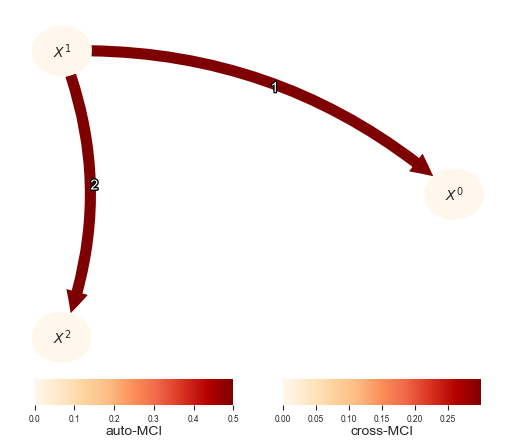

In [15]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    vmin_edges=0.,
    vmax_edges = 0.3,
    edge_ticks=0.05,
    cmap_edges='OrRd',
    vmin_nodes=0,
    vmax_nodes=.5,
    node_ticks=.1,
    cmap_nodes='OrRd',
    ); plt.show()

Here CMIknn correctly detects the true links and also unveils the spurious link. While CMIknn may now seem as the best independence test choice, we have to note that the generality comes at the cost of much lower power for the case that the dependencies actually follow some parametric form. Then ParCorr or GPDC are much more powerful measures. Of course, ParCorr also detects linear links better than GPDC. 

Another note: CMIknn has a huge computational cost because of the shuffle testing. You can decrease the number of shuffle samples by ``sig_samples`` (at the cost of a larger error in the p-value estimate).

## 2a. Categorical / symbolic time series

Categorical or symbolic (or discrete) data doesn't have an order or metric among the values, think apples and pears. To accommodate such time series, Tigramite includes the ``Gsquared`` and ``CMIsymb`` conditional independence tests. Both are estimated directly from the histogram of discrete values. To obtain the null distribution, ``Gsquared`` uses $\chi^2$ (with degrees of freedom adjusted for zero entries) which is valid only asymptotically (depends on data). For smaller sample sizes use the CMIsymb class which includes a local permutation test based on conditional mutual information, CMIsymb takes much more computation time then.

In the process below $X^0,X^1$ both have two categories and $X^2$ has three. The probabilities of $X^0,X^2$ depend on those of $X^1$ acting as a confounder.

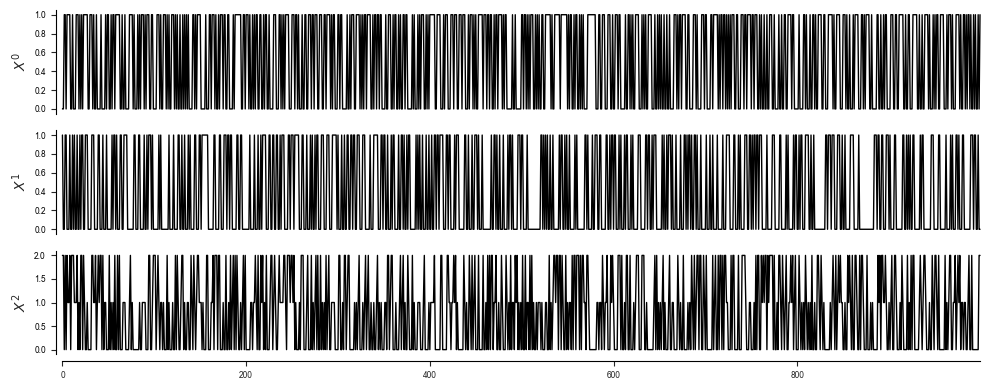

In [16]:
T = 1000
def get_data(T, seed=1):
    random_state = np.random.default_rng(seed)

    data = random_state.binomial(n=1, p=0.4, size=(T, 3))
    for t in range(T):
        prob = 0.4+data[t-1, 1].squeeze()*0.2
        data[t, 0] = random_state.choice([0, 1], p=[prob, 1.-prob])
        prob = 0.4+data[t-2, 1].squeeze()*0.2
        data[t, 2] = random_state.choice([0, 1, 2], p=[prob, (1.-prob)/2., (1.-prob)/2.])
    return data
dataframe = pp.DataFrame(get_data(T), var_names=var_names)
tp.plot_timeseries(dataframe, figsize=(10,4)); plt.show()

Here we focus on ``Gsquared``. Note that the test G2-statistic value scales with the sample size, but it is related to conditional mutual information by $G=2n CMI$ where $n$ is the sample size. Hence, we transform ``val_matrix`` here to get a better interpretable (and plottable) quantity.

In [17]:
gsquared = Gsquared(significance='analytic')
pcmci_cmi_symb = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=gsquared)
results = pcmci_cmi_symb.run_pcmci(tau_min = 1, tau_max=2, pc_alpha=0.2, alpha_level = 0.01)

val_matrix = results['val_matrix']
val_matrix /= (2.*T)

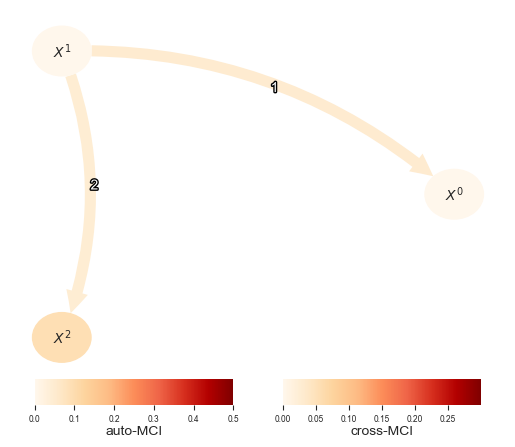

In [18]:
tp.plot_graph(
    val_matrix=val_matrix,
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    vmin_edges=0.,
    vmax_edges = 0.3,
    edge_ticks=0.05,
    cmap_edges='OrRd',
    vmin_nodes=0,
    vmax_nodes=.5,
    node_ticks=.1,
    cmap_nodes='OrRd',
    ); plt.show()

See the separate tutorial on ``CMIsymb`` and also ``CMIknnMixed`` that discusses dealing with (combinations of) continuous and categorical variables, and even variables that contain both types.

``CMIsymb`` here takes much longer and gives the same result, but for smaller sample sizes and higher dimensional condition sets (and/or more categorical values) the asymptotic null distribution of ``Gsquared`` may no longer be valid and then ``CMIsymb`` is preferred.

In [19]:
cmi_symb = CMIsymb(significance='shuffle_test')
pcmci_cmi_symb = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=cmi_symb)
results = pcmci_cmi_symb.run_pcmci(tau_min = 1, tau_max=2, pc_alpha=0.2, alpha_level = 0.01)

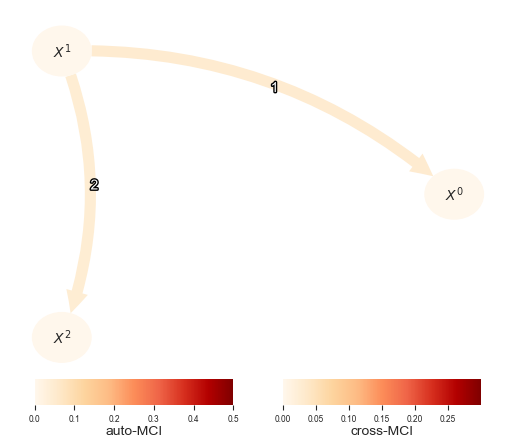

In [20]:
tp.plot_graph(
    val_matrix=val_matrix,
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    vmin_edges=0.,
    vmax_edges = 0.3,
    edge_ticks=0.05,
    cmap_edges='OrRd',
    vmin_nodes=0,
    vmax_nodes=.5,
    node_ticks=.1,
    cmap_nodes='OrRd',
    ); plt.show()

## 2b. Mixed categorical / continuous time series

Often one may have a situation with a dataset where some variables are categorical and some are continuous. This case can be addressed by the ``RegressionCI`` independence test. Then the type for each variable must be set in the dataframe by the ``type_mask`` argument. This is implemented more generally here as a binary data array of same shape as data which describes whether individual samples in a variable (or all samples) are continuous or discrete: 0s for continuous variables and 1s for discrete variables. Here all samples of a variable have to be the same type.

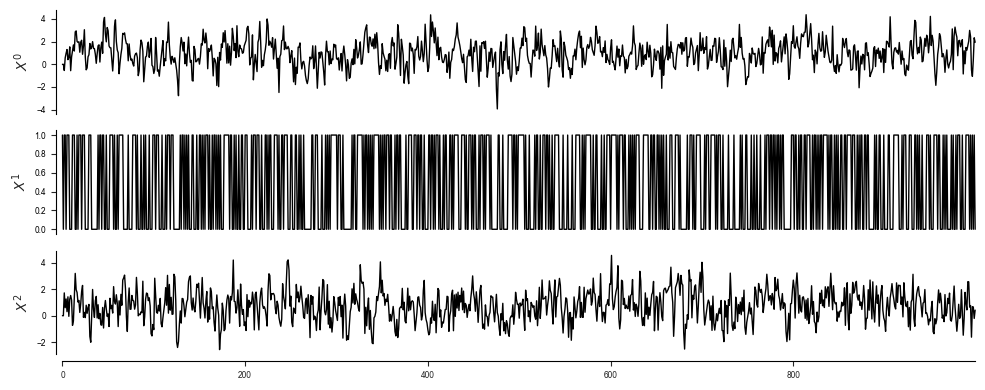

In [21]:
# Generate some mixed-type data with a binary variable (can also be multinomial) causing two continuous ones.
random_state = np.random.default_rng(42)
T = 1000
data = np.zeros((T, 3))
data[:, 1] = random_state.binomial(n=1, p=0.5, size=T)
for t in range(2, T):
    data[t, 0] = 0.5 * data[t-1, 0] + random_state.normal(0.2 + data[t-1, 1] * 0.6, 1)
    data[t, 2] = 0.4 * data[t-1, 2] + random_state.normal(0.2 + data[t-2, 1] * 0.6, 1)

type_mask = np.zeros(data.shape, dtype='int')
# X0 is continuous, encoded as 0 in type_mask
type_mask[:,0] = 0
# X1 is discrete, encoded as 1 in type_mask
type_mask[:,1] = 1
# X2 is continuous, encoded as 0 in type_mask
type_mask[:,2] = 0

dataframe = pp.DataFrame(data,
                         type_mask=type_mask,
                         var_names=var_names)
tp.plot_timeseries(dataframe, figsize=(10,4)); plt.show()

In [22]:
regressionCI = RegressionCI(significance='analytic')

pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=regressionCI)
results = pcmci.run_pcmci(tau_min = 1, tau_max=2, pc_alpha=0.2, alpha_level = 0.01)

# Also here the test statistic values are not very useful
val_matrix = results['val_matrix']
val_matrix /= (2.*T)

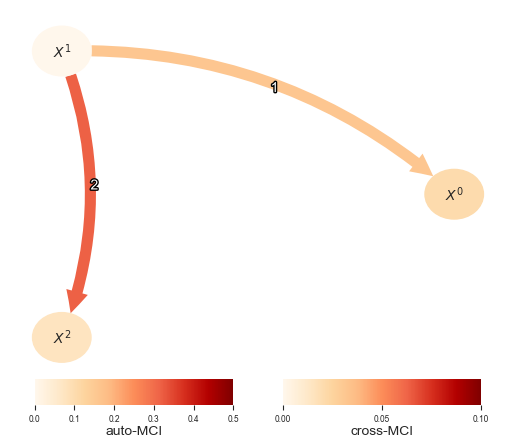

In [23]:
tp.plot_graph(
    val_matrix=val_matrix,
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    vmin_edges=0.,
    vmax_edges = 0.1,
    edge_ticks=0.05,
    cmap_edges='OrRd',
    vmin_nodes=0,
    vmax_nodes=.5,
    node_ticks=.1,
    cmap_nodes='OrRd',
    ); plt.show()